In [106]:
import numpy as np

from keras.utils.np_utils import to_categorical   
import tensorflow as tf
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.datasets import imdb
from keras import preprocessing
from keras.optimizers import Adam
import time
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn import metrics

from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

#Lists to hold model data
Networks = []
TestLabels = []
Processing_Time = []
Training_Set_Accuracy = []
Test_Set_Accuracy = []
History = []
Predicts = []
Classes = []

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 200

max_epochs = 100  
earlystop_callback = \
    tf.keras.callbacks.EarlyStopping(monitor='val_acc',\
    min_delta=0.01, patience=5, verbose=0, mode='auto',\
    baseline=None, restore_best_weights=False)


In [107]:
def updateModeldata(name):     
    Networks.append(name)
    Processing_Time.append(elapsed)
    TestLabels.append(y_test)
    score, acc_train = model.evaluate(x_train, y_train)
    score, acc_test = model.evaluate(x_test, y_test)
    Training_Set_Accuracy.append(acc_train)
    Test_Set_Accuracy.append(acc_test)
    History.append(history)
    Predicts.append(y_preds)            
    Classes.append(y_classes)

In [108]:
def plotLosses(network):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])


    plt.title('Sentiment loss with ' + network)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [109]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)

In [110]:
# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [111]:
model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks = [earlystop_callback])
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)

updateModeldata('Dense Embedding')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 8)            80000     
_________________________________________________________________
flatten_14 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 1601      
Total params: 81,601
Trainable params: 81,601
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 4s 181us/step - loss: 0.5990 - acc: 0.6921 - val_loss: 0.4076 - val_acc: 0.8392
Epoch 2/100
20000/20000 [==============================] - 3s 157us/step - loss: 0.3120 - acc: 0.8786 - val_loss: 0.2985 - val_acc: 0.8788
Epoch 3/100
20000/20000 [==============================] - 3s 157us/step - 

In [112]:
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
# create the model
model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks = [earlystop_callback])
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)

updateModeldata('Convolutional Embedding')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 32)           320000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 200, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 250)               800250    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 251       
Total params: 1,123,605
Trainable params: 1,123,605
Non-trainable params: 0
_________________________________________________________________


In [114]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# truncate and pad input sequences
max_review_length = 500
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
# create the model
model = Sequential()
model.add(Embedding(max_features, 32, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks = [earlystop_callback])
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)

updateModeldata('LSTM Embedding')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 32)           320000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 101       
Total params: 373,301
Trainable params: 373,301
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 171s 9ms/step - loss: 0.4468 - acc: 0.7793 - val_loss: 0.3672 - val_acc: 0.8400
Epoch 2/100
20000/20000 [==============================] - 172s 9ms/step - loss: 0.2631 - acc: 0.8962 - val_loss: 0.3311 - val_acc: 0.8572
Epoch 3/100
20000/20000 [==============================] - 172s 9ms/step 

In [117]:
import os

imdb_dir = '/home/jbarker6706/Unbuntu/Data/aclImdb_v1/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [118]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 8000  # We will be training on 200 samples
test_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_test = data[training_samples: training_samples + test_samples]
y_test = labels[training_samples: training_samples + test_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [119]:
glove_dir = '/home/jbarker6706/Unbuntu/Data/glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [120]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [121]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [122]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [123]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = [earlystop_callback])
model.save_weights('pre_trained_glove_model.h5')
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)
updateModeldata('Dense glove.6B.100d')

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 2s 315us/step - loss: 0.7044 - acc: 0.5067 - val_loss: 0.6933 - val_acc: 0.4925
Epoch 2/100
6400/6400 [==============================] - 1s 185us/step - loss: 0.6931 - acc: 0.5081 - val_loss: 0.6933 - val_acc: 0.4925
Epoch 3/100
6400/6400 [==============================] - 1s 184us/step - loss: 0.6930 - acc: 0.5088 - val_loss: 0.6934 - val_acc: 0.4925
Epoch 4/100
6400/6400 [==============================] - 1s 186us/step - loss: 0.6924 - acc: 0.5089 - val_loss: 0.6934 - val_acc: 0.4925
Epoch 5/100
6400/6400 [==============================] - 1s 187us/step - loss: 0.6926 - acc: 0.5091 - val_loss: 0.6935 - val_acc: 0.4925
Epoch 6/100
10000/10000 [==============================] - 1s 74us/step


In [128]:
print(maxlen)

100


In [166]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 100, 32)           9632      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 50, 32)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 1601      
Total params: 1,011,233
Trainable params: 1,011,233
Non-trainable params: 0
_________________________________________________________________


In [167]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [163]:
print(x_train.shape)
print(y_train.shape)

(8000, 100)
(8000,)


In [168]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks = [earlystop_callback])
model.save_weights('pre_trained_glove_model.h5')
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)
updateModeldata('Convolutional glove.6B.100d')

Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 3s 397us/step - loss: 0.6747 - acc: 0.5905 - val_loss: 0.6062 - val_acc: 0.6881
Epoch 2/100
6400/6400 [==============================] - 1s 208us/step - loss: 0.5280 - acc: 0.7377 - val_loss: 0.5212 - val_acc: 0.7481
Epoch 3/100
6400/6400 [==============================] - 1s 212us/step - loss: 0.4378 - acc: 0.7988 - val_loss: 0.4802 - val_acc: 0.7669
Epoch 4/100
6400/6400 [==============================] - 1s 209us/step - loss: 0.3844 - acc: 0.8286 - val_loss: 0.4697 - val_acc: 0.7800
Epoch 5/100
6400/6400 [==============================] - 1s 211us/step - loss: 0.3480 - acc: 0.8516 - val_loss: 0.4850 - val_acc: 0.7762
Epoch 6/100
6400/6400 [==============================] - 1s 210us/step - loss: 0.3087 - acc: 0.8731 - val_loss: 0.4772 - val_acc: 0.7725
Epoch 7/100
6400/6400 [==============================] - 1s 210us/step - loss: 0.2695 - acc: 0.8977 - val_loss: 0.5059 - val_acc: 

In [151]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [153]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
start = time.perf_counter()
history = model.fit(x_train, y_train,
                    epochs=max_epochs,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks = [earlystop_callback])
elapsed = time.perf_counter() - start
y_preds = model.predict(x_test, verbose=0)
y_classes = model.predict_classes(x_test, verbose=0)

updateModeldata('LSTM glove.6B.100d')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 101       
Total params: 1,080,501
Trainable params: 80,501
Non-trainable params: 1,000,000
_________________________________________________________________
Train on 6400 samples, validate on 1600 samples
Epoch 1/100
6400/6400 [==============================] - 33s 5ms/step - loss: 0.6252 - acc: 0.6425 - val_loss: 0.5366 - val_acc: 0.7438
Epoch 2/100
6400/6400 [==============================] - 31s 5ms/step - loss: 0.5182 - acc: 0.7473 - val_loss: 0.4554 - val_acc: 0.7913
Epoch 3/100
6400/6400 [==============================] - 32s 5ms/step -

In [170]:
from prettytable import PrettyTable
table = PrettyTable(['Network','Process_Time', 
                     'Train_Set_Accuracy', 'Test_Set_Accuracy'])
for x in range(0, 6):
    table.add_row([Networks[x],round(Processing_Time[x], 3), 
                   round(Training_Set_Accuracy[x], 3), 
                   round(Test_Set_Accuracy[x], 3)])
print(table)


+-----------------------------+--------------+--------------------+-------------------+
|           Network           | Process_Time | Train_Set_Accuracy | Test_Set_Accuracy |
+-----------------------------+--------------+--------------------+-------------------+
|       Dense Embedding       |    28.849    |       0.952        |       0.874       |
|   Convolutional Embedding   |    29.257    |       0.974        |       0.862       |
|        LSTM Embedding       |   1541.407   |       0.967        |       0.847       |
|     Dense glove.6B.100d     |    8.379     |       0.506        |       0.495       |
|      LSTM glove.6B.100d     |   355.175    |       0.925        |       0.819       |
| Convolutional glove.6B.100d |    13.761    |       0.923        |       0.756       |
+-----------------------------+--------------+--------------------+-------------------+


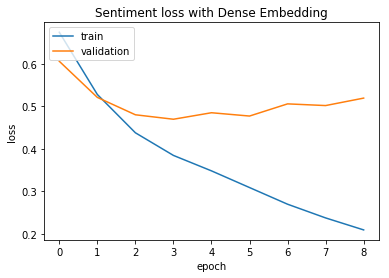

Accuracy: 0.874000
Precision: 0.874359
Recall: 0.873520
F1 score: 0.873939
Cohens kappa: 0.748000
ROC AUC: 0.945366
[[10931  1569]
 [ 1581 10919]]


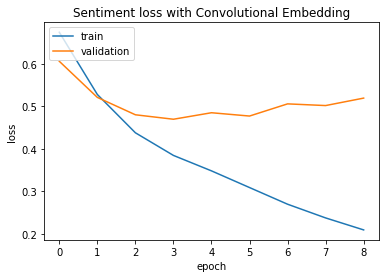

Accuracy: 0.862000
Precision: 0.862755
Recall: 0.860960
F1 score: 0.861856
Cohens kappa: 0.724000
ROC AUC: 0.936985
[[10788  1712]
 [ 1738 10762]]


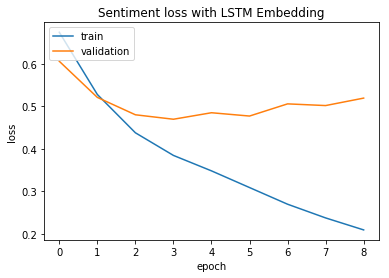

Accuracy: 0.846560
Precision: 0.841210
Recall: 0.854400
F1 score: 0.847754
Cohens kappa: 0.693120
ROC AUC: 0.911411
[[10484  2016]
 [ 1820 10680]]


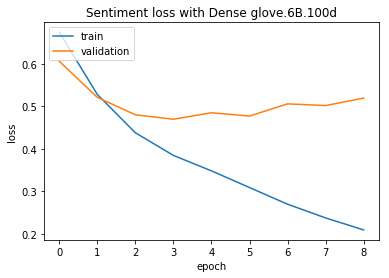

Accuracy: 0.494900
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500101
[[4949    0]
 [5051    0]]


/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


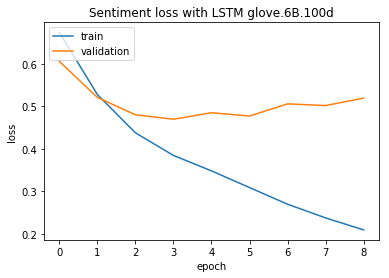

Accuracy: 0.819300
Precision: 0.794909
Recall: 0.865571
F1 score: 0.828737
Cohens kappa: 0.638231
ROC AUC: 0.901842
[[3821 1128]
 [ 679 4372]]


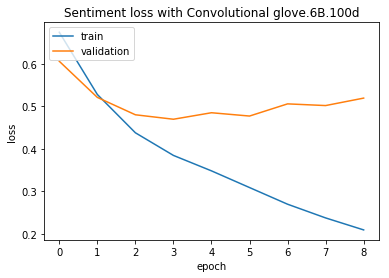

Accuracy: 0.755900
Precision: 0.742746
Recall: 0.790537
F1 score: 0.765896
Cohens kappa: 0.511425
ROC AUC: 0.836420
[[3566 1383]
 [1058 3993]]


In [171]:
for x in range(0, 6):
    plotLosses(Networks[x])
    yhat_probs = Predicts[x][:, 0]
    yhat_classes = Classes[x][:, 0]
    y_test = TestLabels[x]
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)
    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)  